Попробую сделать что-то связанное с RNN'кой

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
start_token = " "

def read_names(path_to_file):
  global start_token
  with open(path_to_file) as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]
    return names

In [ ]:
try:
  names = read_names('names')
except FileNotFoundError:
  !wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/week0_10_embeddings_and_seq2seq/names -O names
  names = read_names('names')

--2023-03-26 13:34:41--  https://raw.githubusercontent.com/girafe-ai/ml-course/master/week0_10_embeddings_and_seq2seq/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.004s  

2023-03-26 13:34:41 (15.2 MB/s) - ‘names’ saved [55868/55868]



In [ ]:
print('n samples = ', len(names))
for x in names[::1000]:
  print(x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


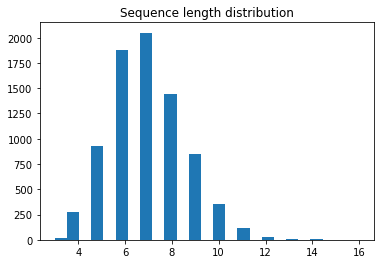

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

Text processing

In [ ]:
#all unique characters go here
tokens = set()
for name in names:
  tokens.update(set(name))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


In [ ]:
token_to_id = {token : idx for idx, token in enumerate(tokens) }#<dictionary of symbol -> its identifier (index in tokens list)>

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad
    print(max(map(len, names)))

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::1999]))
print(to_matrix(names[::1999]))

 Abagael
 Glorianna
 Priscella
 Giordano
10
[[32 45 42 41  4 41 11 30 32 32]
 [32 24 30 31 29 43 41 47 47 41]
 [32 18 29 43 28  3 11 30 30 41]
 [32 24 43 31 29 46 41 47 31 32]]


**Recurrent neural network**

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim = 1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

**RNN loop**

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()
loss.backward()

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

***TRAINING LOOP***

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

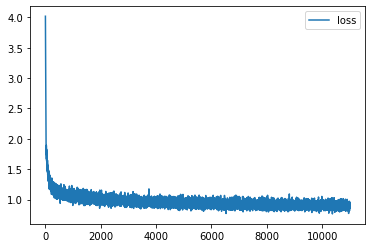

In [ ]:
MAX_LENGTH = 16

for i in range(1500):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]).mean()

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

RNN sampling

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Koren          
 Stan           
 Nish           
 Eddann         
 Gew            
 Tedfira        
 Dovin          
 Hadore         
 Clarjay        
 Andolee        


In [ ]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Anas'))

 Anaslic        
 Anassa         
 Anas a         
 Anasselle      
 Anasain        
 Anasa          
 Anasinta       
 Anasha         
 Anasua         
 Anasha         
 Anasceline     
 Anasta         
 Anastat        
 Anassa         
 Anasie         
 Anasta         
 Anastiona      
 Anastas        
 Anashis        
 Anase-Janne    
 Anasya         
 Anasba         
 Anasold        
 Anasona        
 Anastacke      
 Anaster        
 Anas ulee      
 Anashann       
 Anasle         
 Anastyne       
 Anasla         
 Anas           
 Anasause       
 Anasy          
 Anastens       
 Anasha         
 Anasoz         
 Anasey         
 Anashe         
 Anasha         
 Anastiane      
 Anasea         
 Anasta         
 Anasita        
 Anassa         
 Anas           
 Anasta         
 Anas           
 Anasta         
 Anastausende   
